In [28]:
from __future__ import print_function
# import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR


In [29]:
torch.cuda.is_available()

True

In [30]:
from IPython.display import clear_output
clear_output()

In [31]:
import pennylane as qml
import matplotlib.pyplot as plt
from pennylane import numpy as np
from pennylane.templates import RandomLayers
from tqdm import tqdm, trange


In [32]:
kernel_2_dev = qml.device("default.qubit", wires=4)

In [33]:
@qml.qnode(kernel_2_dev, interface="torch")
def kernel_2_circuit(phi, rand_params):

    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

In [34]:
class QUANV2(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, image, params):
        """Convolves the input image with many applications of the same quantum circuit."""
        ## image.shape: (B, 1, 28, 28)
        # out = torch.zeros((batch_size, 4, 14, 14), device='cuda:0')
        # out = torch.zeros((batch_size, 4, 27, 27), device='cuda:0')
        out = torch.zeros(image.shape, device="cuda:0")

        for i in range(image.shape[0]):
            # Loop over the coordinates of the top-left pixel of 2x2 squares
            for j in range(0, 28, 2):
                for k in range(0, 28, 2):
                    # Process a squared 2x2 region of the image with a quantum circuit
                    subregion = [
                            image[i, 0, j, k],
                            image[i, 0, j, k + 1],
                            image[i, 0, j + 1, k],
                            image[i, 0, j + 1, k + 1]
                        ]
                    q_results = kernel_2_circuit(
                        subregion,
                        params # 4 random parameters
                    )
                    # np.random.uniform(high=2*np.pi, size=(1, 4))
                    # Assign expectation values to different channels of the output pixel (j/2, k/2)
                    # for c in range(4):
                    #     out[i, c, j // 2, k // 2] = q_results[c]
                    out[i, 0, j, k] = q_results[0]
                    out[i, 0, j, k + 1] = q_results[1]
                    out[i, 0, j + 1, k] = q_results[2]
                    out[i, 0, j + 1, k + 1] = q_results[3]

        return out

Addition at the beginning

In [35]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.quanv2 = QUANV2()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x, params):
        qx = self.quanv2(x, params) # quanvolution
        x = x + qx # skip connection

        # working cnn structure
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)

        return output


Add the output of quanv to the middle of the network

In [36]:
class NetV2(nn.Module):
    def __init__(self):
        super(NetV2, self).__init__()
        self.quanv2 = QUANV2()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

        # a layer to downsize the quanv output for the addition with middle layer output
        self.fc3 = nn.Linear(784, 128)

    def forward(self, x, params):
        qx = self.quanv2(x, params) # quanvolution
        # B, 1, 28, 28
        qx = torch.flatten(qx, 1)
        qx = self.fc3(qx) 
        # qx = torch.reshape(qx, ())

        # working cnn structure
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        # x shape: B, 64, 24, 24

        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)

        x = x + qx

        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)

        return output

Concatenation rather than addition

In [37]:
class NetV3(nn.Module):
    def __init__(self):
        super(NetV3, self).__init__()
        self.quanv2 = QUANV2()
        self.conv1 = nn.Conv2d(2, 32, 3, 1) # changed from 1 32 3 1
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x, params):
        qx = self.quanv2(x, params) # quanvolution
        x = torch.cat((x, qx), dim=1) # concatenate
        # B 1 28 28
        # print("x.shape", x.shape)

        # working cnn structure
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)

        return output

Concatenation and skipping

In [38]:
class NetV4(nn.Module):
    def __init__(self):
        super(NetV4, self).__init__()
        self.quanv2 = QUANV2()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x, params):
        qx = self.quanv2(x, params) # quanvolution
        x = torch.cat((x, qx)) # concatenate
        # print("x.shape", x.shape)

        # working cnn structure
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)

        return output

In [39]:
def train(model, device, train_loader, optimizer, epoch):
    params = np.random.uniform(high=2*np.pi, size=(1, 4))
    params_torch = torch.tensor(params, requires_grad=True)

    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data, params_torch)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 5 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

    return params_torch


In [14]:
def test(model, device, test_loader, trained_params):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data, trained_params)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


In [15]:
def main(use_cuda=True, use_mps=False, batch_size=64, subset_size=1000, num_epochs=14, save_model=True):
    torch.manual_seed(1)

    if use_cuda:
        device = torch.device("cuda")
    elif use_mps:
        device = torch.device("mps")
    else:
        device = torch.device("cpu")

    train_kwargs = {'batch_size': batch_size}
    test_kwargs = {'batch_size': 1000}
    if use_cuda:
        cuda_kwargs = {'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
    dataset1 = datasets.FashionMNIST('../data', train=True, download=True,
                       transform=transform)
    dataset2 = datasets.FashionMNIST('../data', train=False,
                       transform=transform)
    dataset1 = torch.utils.data.Subset(dataset1, np.arange(subset_size))
    dataset2 = torch.utils.data.Subset(dataset2, np.arange(subset_size))
    train_loader = torch.utils.data.DataLoader(dataset1, **train_kwargs)
    test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

    model = Net().to(device)
    optimizer = optim.Adadelta(model.parameters(), lr=1.0)

    scheduler = StepLR(optimizer, step_size=1, gamma=0.7)
    for epoch in trange(1, num_epochs + 1):
        trained_params = train(model, device, train_loader, optimizer, epoch)
        test(model, device, test_loader, trained_params)
        scheduler.step()

    if save_model:
        torch.save(model.state_dict(), "fashion_mnist_qnn.pt")



Net

In [16]:
import torch
torch.cuda.empty_cache()

In [17]:
import gc
gc.collect()

706

In [ ]:
main(batch_size=10, subset_size=2000, num_epochs=14)

In [2]:
v1 = [73.6,76.8,79.3,78.5,80.1,80.2,80.9,80.4,80.6,81.0,80.5,80.9,81.2,81.2]
v1 = [i/100 for i in v1]

In [11]:
v2 = [1450/2000, 1440/2000, 1618/2000, 1676/2000, 1689/2000, 1711/2000, 1701/2000, 1709/2000, 1708/2000, 1716/2000, 1714/2000, 1717/2000, 1717/2000, 1717/2000 ]
print(v2)

[0.725, 0.72, 0.809, 0.838, 0.8445, 0.8555, 0.8505, 0.8545, 0.854, 0.858, 0.857, 0.8585, 0.8585, 0.8585]


In [5]:
v3 = [755/1000, 770/1000, 775/1000, 787/1000, 796/1000, 804/1000, 803/1000, 808/1000, 811/1000, 808/1000, 810/1000, 807/1000, 812/1000, 812/1000]
print(v3)

[0.755, 0.77, 0.775, 0.787, 0.796, 0.804, 0.803, 0.808, 0.811, 0.808, 0.81, 0.807, 0.812, 0.812]


In [ ]:
v4 = []
print(v4)

In [14]:
v5 = [1589/2000, 1640/2000, 1657/2000, 1704/2000, 1697/2000, 1687/2000, 1719/2000, 1724/2000, 1730/2000, 1725/2000, 1733/2000, 1734/2000, 1735/2000, 1738/2000]
print(v5)

[0.7945, 0.82, 0.8285, 0.852, 0.8485, 0.8435, 0.8595, 0.862, 0.865, 0.8625, 0.8665, 0.867, 0.8675, 0.869]


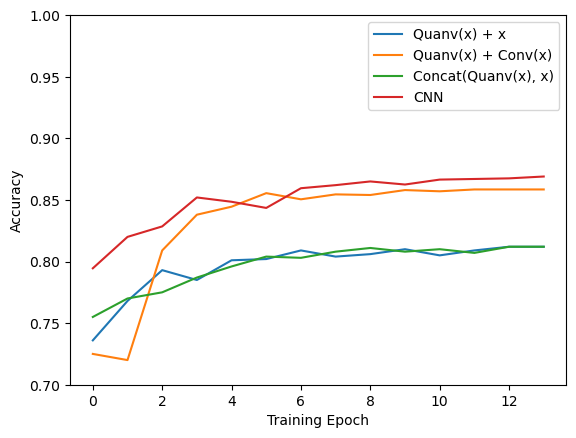

In [21]:
import matplotlib.pyplot as plt
  
# create data
x = [i for i in range(14)]
  
# plot lines
plt.plot(x, v1, label = "Quanv(x) + x")
plt.plot(x, v2, label = "Quanv(x) + Conv(x)")
plt.plot(x, v3, label = "Concat(Quanv(x), x)")
# plt.plot(x, v4, label = "line 2")
plt.plot(x, v5, label = "CNN")
plt.xlabel("Training Epoch")
plt.ylabel("Accuracy")
plt.ylim(0.7, 1)
plt.legend()
# plt.show()
plt.savefig("fashion_mnist.png")

In [22]:
from torchviz import make_dot

/home/yinuod/anaconda3/envs/10701/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [45]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
dataset1 = datasets.FashionMNIST('../data', train=True, download=True,
                       transform=transform)
# type(dataset1[0][0])
tensor_list = [i[0] for i in dataset1]
X = torch.stack(tensor_list)

In [57]:
model = Net()
params = np.random.uniform(high=2*np.pi, size=(1, 4))
y = model(X, params)
make_dot(y.mean(), params=dict(model.named_parameters()))

/home/yinuod/anaconda3/envs/10701/lib/python3.9/site-packages/pennylane/math/utils.py:223: UserWarning: Contains tensors of types {'torch', 'autograd'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(
